In [64]:
println("Hello super people!")

Hello super people!


In [65]:
using Random, Plots, Statistics, Combinatorics, LaTeXStrings, CSV, DataFrames, StatsBase


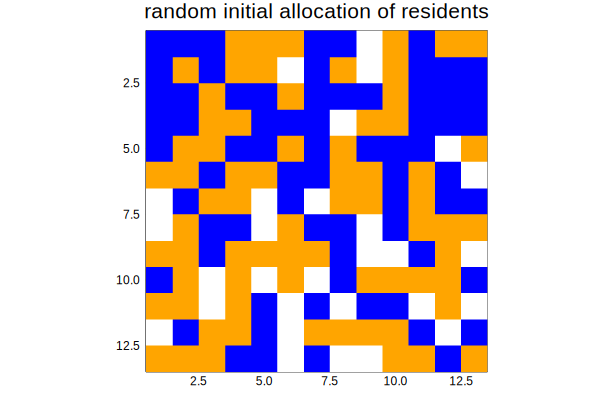

In [66]:

#define the grid
#schelling used originally 13x13 grid
GRID_SIZE = 13
CELL_COUNT = GRID_SIZE^2

THRESHOLD_SAME = 4
THRESHOLD_EDGE = 3
THRESHOLD_CORNER = 2

PP = 5

MM = 10#number of simulations
TT = 25#number of time points in simulation


yellow_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
empty_count = CELL_COUNT - yellow_count - blue_count

#the total number of possible configurations
CELLS_SPACE_SIZE = multinomial(BigInt(yellow_count),BigInt(blue_count),BigInt(empty_count))
#println(CELLS_SPACE_SIZE)

#boltzmann constant
k_b = 1.380649*10^-23


empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

start_grid = shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
h = heatmap(start_grid,title="random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))


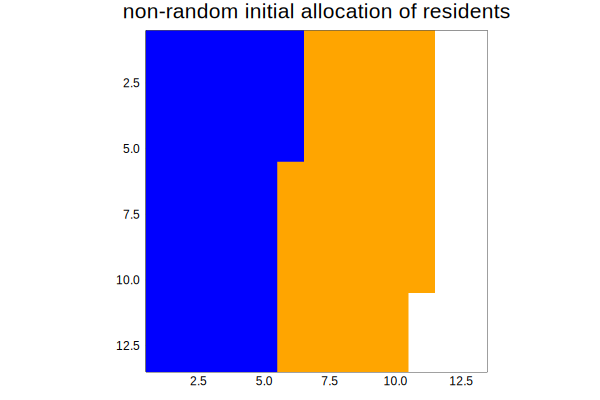

In [67]:
savefig(h,"figs/randomAllocationInit.png")

yellow_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))

empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

set_grid = empty_grid#shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
h2 = heatmap(set_grid,title="non-random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))

In [68]:
savefig(h2,"figs/setAllocation.png")

#macrostate function mapping (eg, what is the total satisfaction of the residents overall the cells, total sum from zero to max)
#function overall_satisfaction(start_grid)

function grid_satisfaction(grid)
    cell_satisfaction = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            
            t=cell_surround_arrayTMP(grid,row,col)  #R2 = R_grid(start_grid)
            tmpBinary = thresholdFN(t,grid[row,col],row,col)
            append!(cell_satisfaction,tmpBinary)
        end
    end
    return sum(cell_satisfaction)
end

function thresholdFN(cellSurroundArray,cellType,row,col)
    homogeneity = length(findall(cellType .== cellSurroundArray))
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end
function cell_surround_arrayTMP(grid,row,col)
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end

    return cell_surrounding
end

R_MAX = grid_satisfaction(set_grid)
println("set grid satisfaction value MAX=",R_MAX)
R_START = grid_satisfaction(start_grid)
println("set grid satisfaction value START=",R_START)


set grid satisfaction value MAX=140
set grid satisfaction value START=53


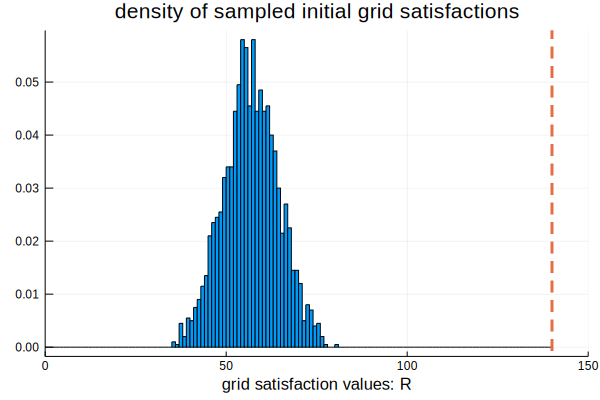

In [69]:
#sample the random intializations and investigate 
function make_random_grid()
    empty_grid = zeros(GRID_SIZE,GRID_SIZE)
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    random_grid = shuffle(empty_grid)
    return random_grid
end
numberOfRandomSamples = 2000
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:numberOfRandomSamples]
normedRandomSatisfactions = randomSatisfactions ./ sum(randomSatisfactions)
pltHist = histogram(randomSatisfactions,bins=0:1:R_MAX,normalize=:probability,xlim=(0,R_MAX+10),title="density of sampled initial grid satisfactions",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)

In [70]:
savefig(pltHist,"figs/histogramOfSampledInitSatisfactions.png")

#llok at not the grid level satisfaction but the single cell level satisfaction
function cell_surround_array(grid,row,col)
    #if((row==1 && col==1))#top left corner
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end
  
    return cell_surrounding
end

function is_cell_satisfied(grid,row,col)
    cellSurroundArray = cell_surround_array(grid,row,col)
    #println(cellSurroundArray)
    cellType = grid[row,col]
    #println(cellType)
    homogeneity = length(findall(cellType .== cellSurroundArray))
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 

#cell_satisfied = is_cell_satisfied(start_grid,8,7)
#println(cell_satisfied)
 


is_cell_satisfied (generic function with 1 method)

In [71]:
#testing for if a cell would be satisfied if it were placed there
function would_cell_be_satisfied(grid,row,col,cellType)
    cellSurroundArray = cell_surround_array(grid,row,col)    
    #println(cellSurroundArray)
    homogeneity = length(findall(cellType .== cellSurroundArray))    
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 

#cell_satisfied = would_cell_be_satisfied(start_grid,7,9,start_grid[2,2])
#println(cell_satisfied)
 

would_cell_be_satisfied (generic function with 1 method)

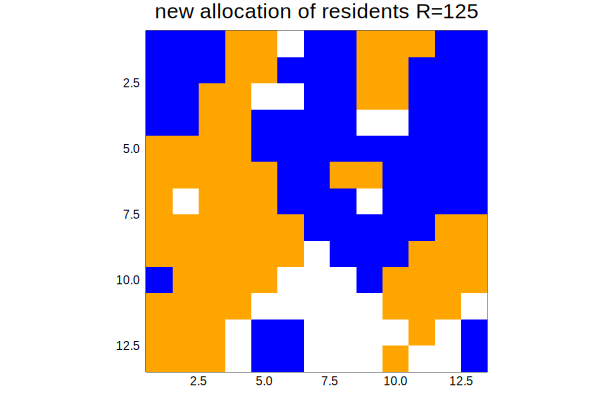

In [72]:
#get non-empty cell set
#Search for an unsatisfied iteratively in all the cells through a shuffled list
#find all empty cells
#shuffle the list of the empty cells
#see if the cell would_cell_be_satisfied in any of the cells in sequence
#no, move on to the next cell
#if yes, change the original cell position to empty and make the new cell the cell type
#loop till all non-empty cells are tested

function move_cells_for_satisfaction(grid)
    
    newGrid = deepcopy(grid)
    nonZeroCells = findall(grid .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)
    satisfiedNonZeroCells = [is_cell_satisfied(newGrid,nzc[1],nzc[2]) for nzc in nonZeroCells2]    
    #R_START = grid_satisfaction(grid)

    #remove (skip) the satisfied, don't include them in the rotation on each iteration
    satisfiedInds = findall(satisfiedNonZeroCells .== 1)
    deleteat!(nonZeroCells2,satisfiedInds)   
    
    for nzc in nonZeroCells2        
        isCellSatisfied = is_cell_satisfied(newGrid,nzc[1],nzc[2])
        
        if(isCellSatisfied != 1)          
            emptyCells = findall(newGrid .== 0)
            emptyCells2 = shuffle(emptyCells)
            #find an empty cell nzc could move to
            moved = false
            for ec in emptyCells2                
                wouldCellBeSatisfied = would_cell_be_satisfied(newGrid,ec[1],ec[2],newGrid[nzc[1],nzc[2]] )
                if(wouldCellBeSatisfied == 1)  
                    
                    newGrid[ec[1],ec[2]] = newGrid[nzc[1],nzc[2]]
                    newGrid[nzc[1],nzc[2]] = 0  
                    #no longer try to move it
                    moved = true
                    break
                end                
            end   
            #=if(moved == false)
                println("cell at i=$(nzc[1]) and j=$(nzc[2]) did not move")
            end=#
        end       
    end
    
    return newGrid
end

newGrid = move_cells_for_satisfaction(start_grid)

satisfiedOneGrid = grid_satisfaction(newGrid)
#println(satisfiedOneGrid)
h3 = heatmap(newGrid,title="new allocation of residents R=$(satisfiedOneGrid)",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))


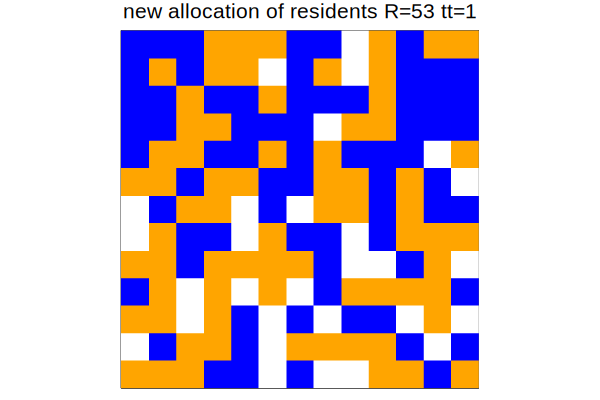

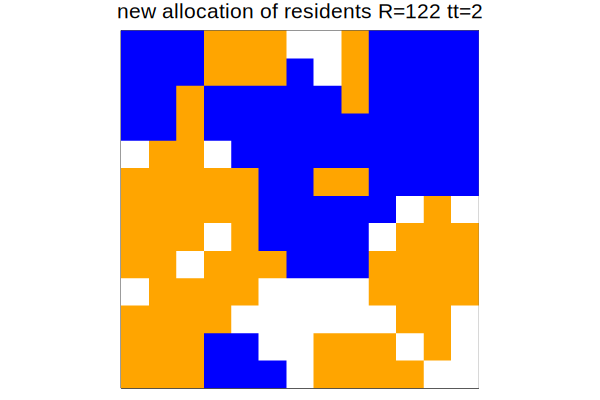

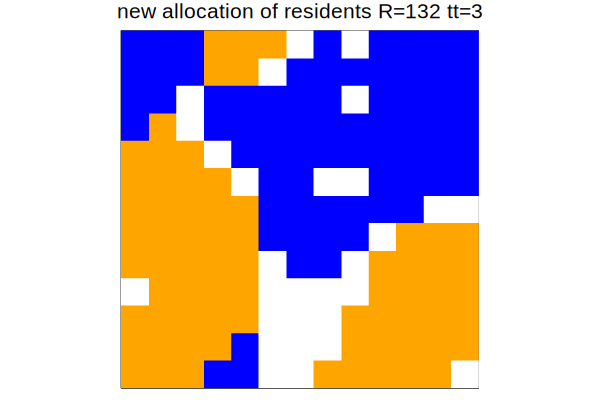

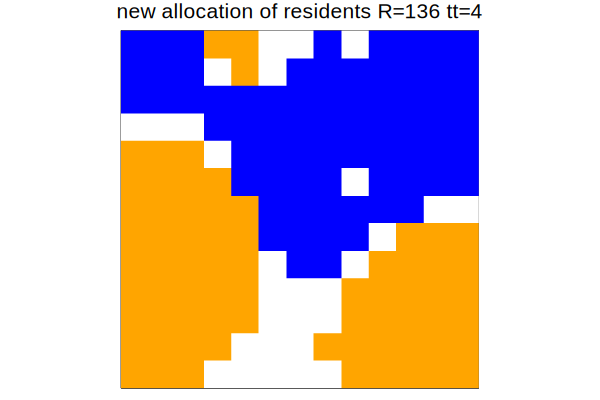

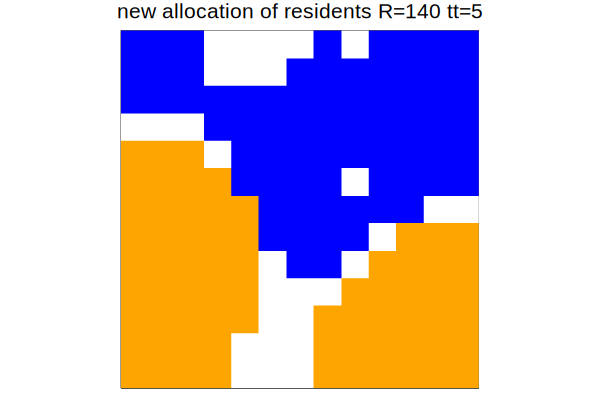

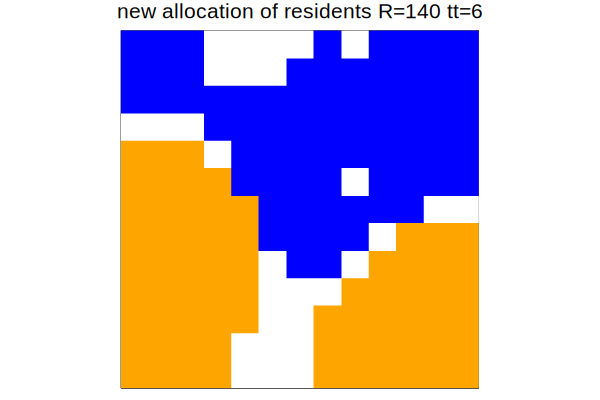

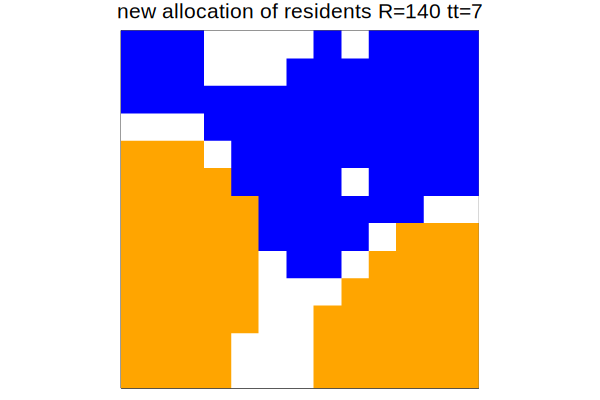

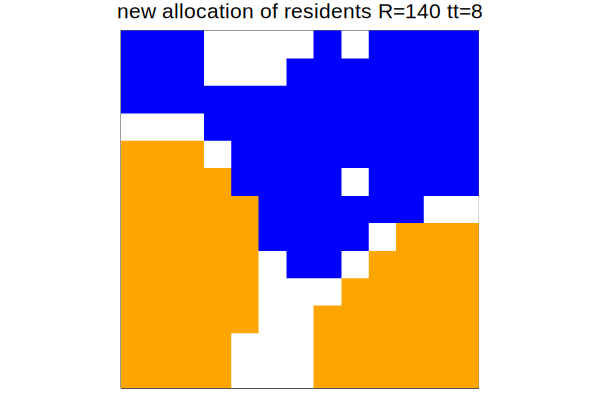

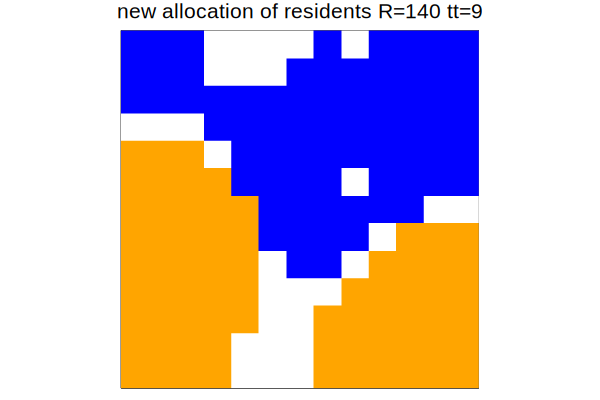

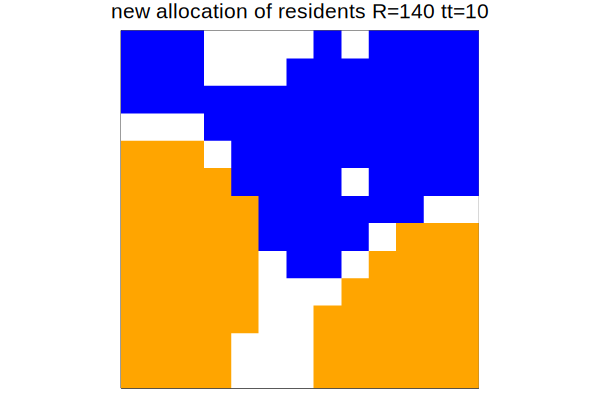

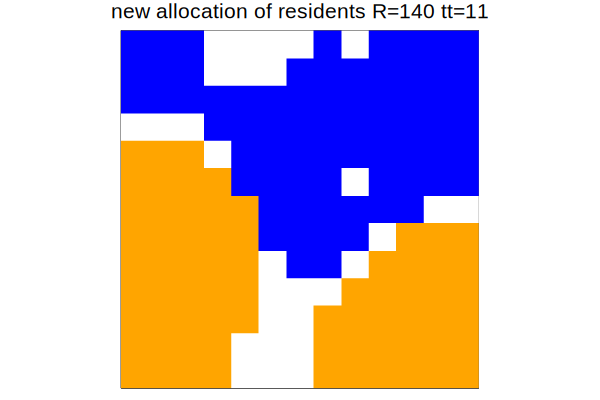

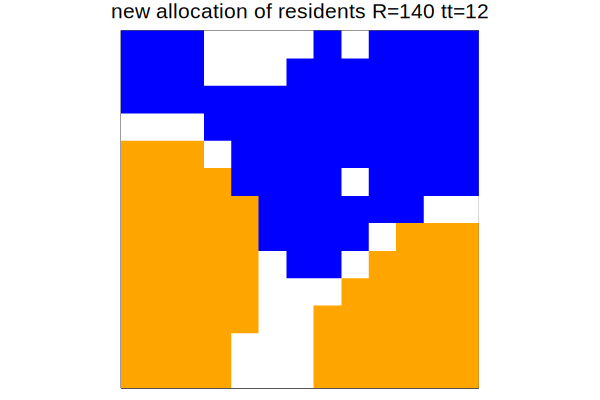

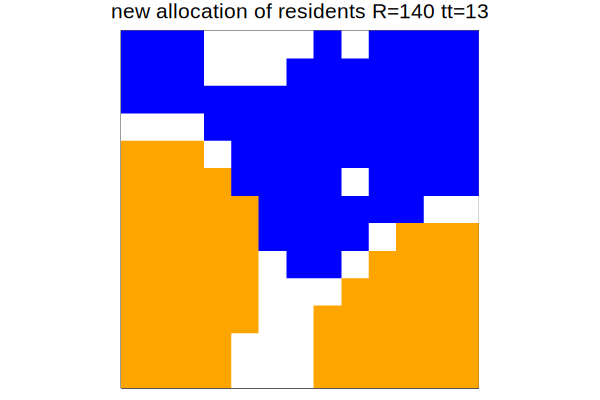

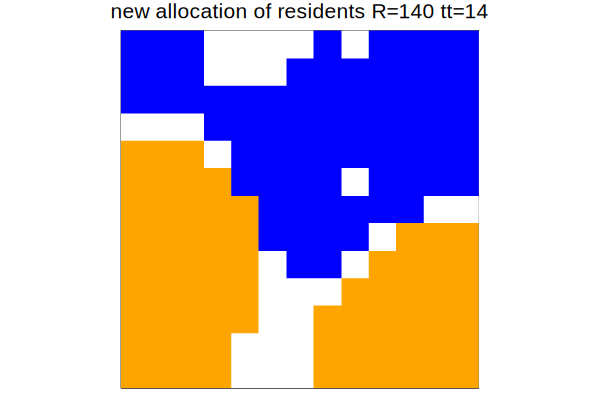

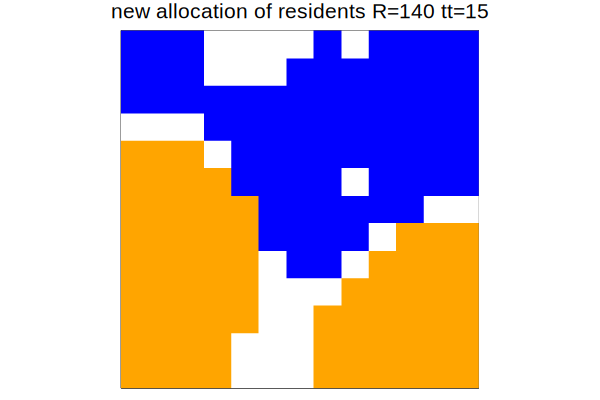

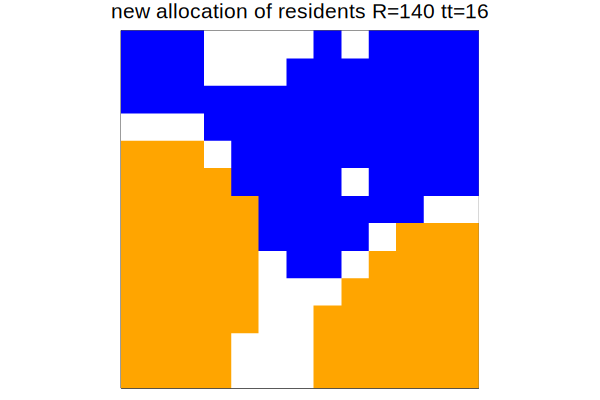

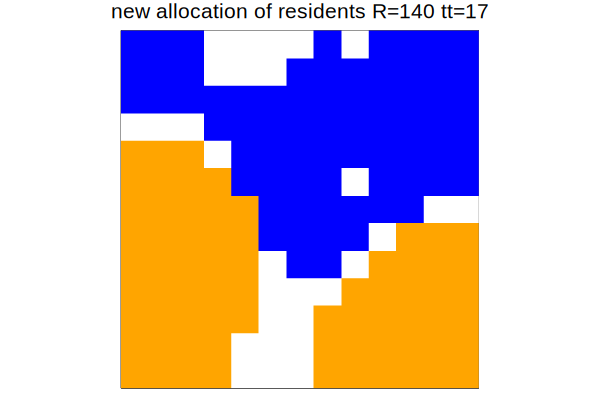

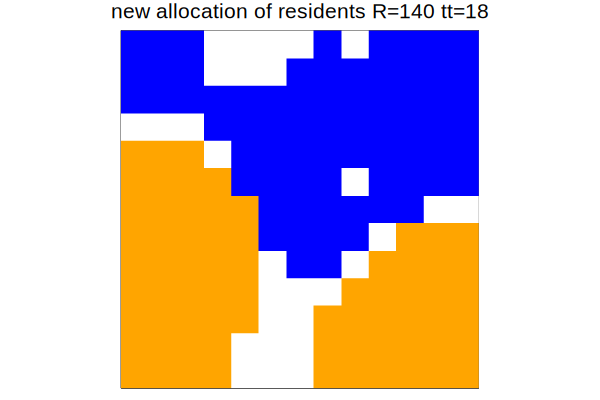

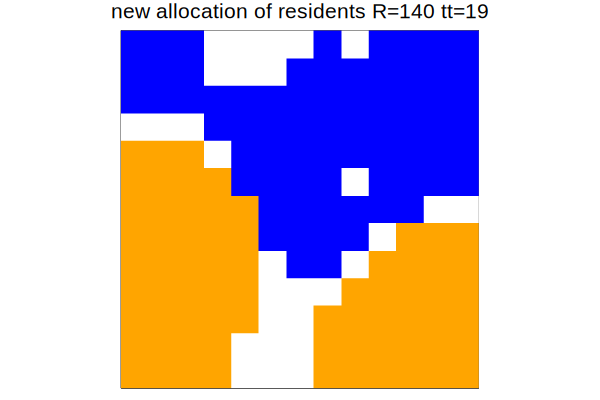

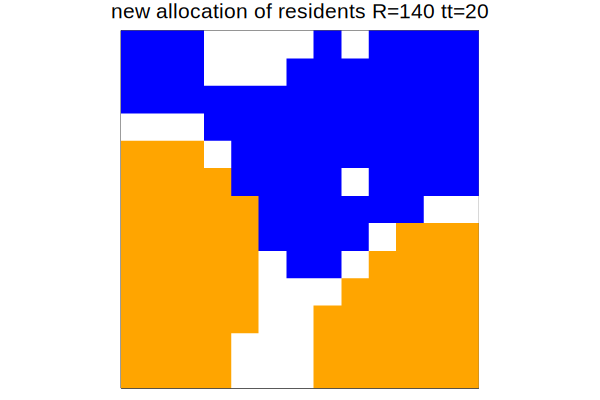

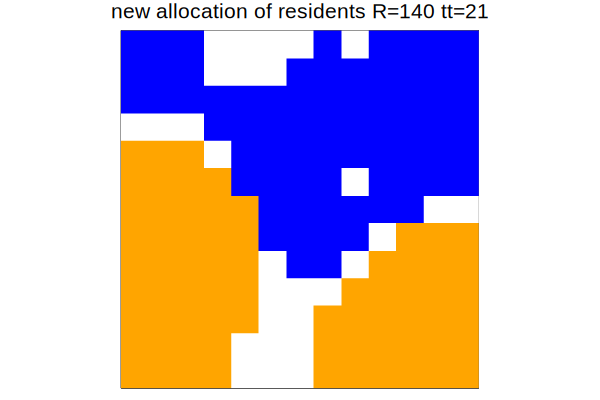

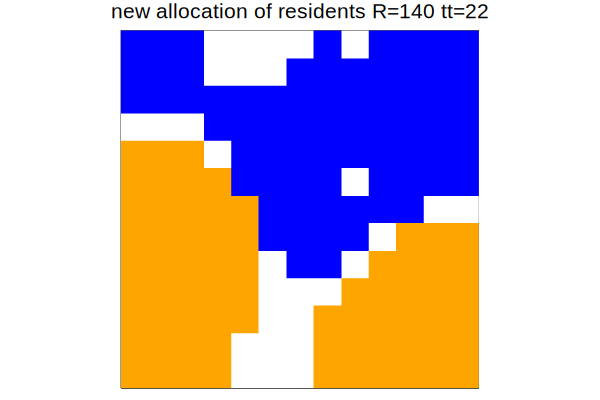

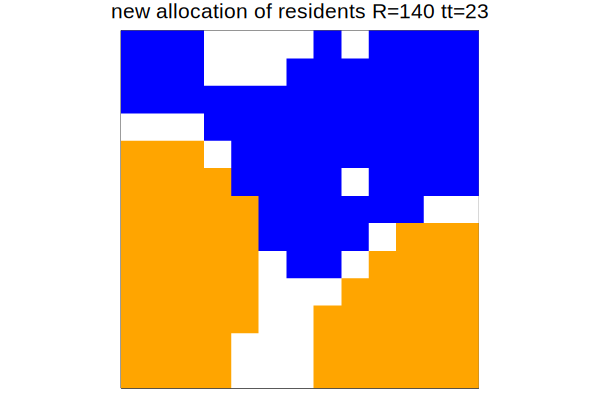

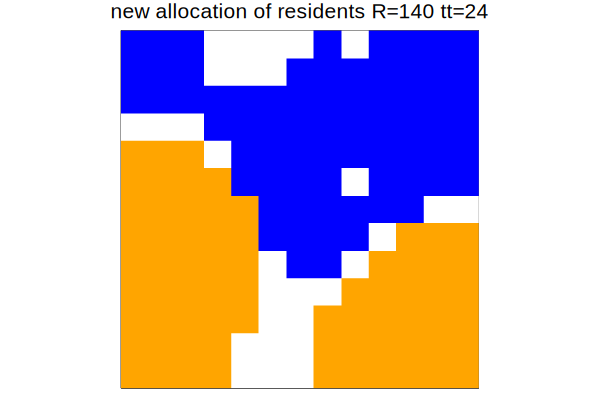

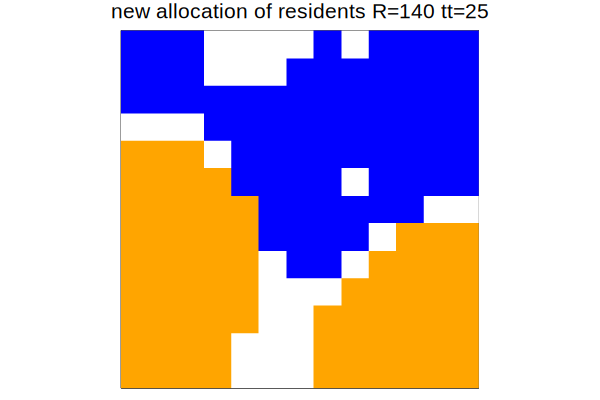

In [73]:
savefig(h3,"figs/newAllocation.png")


gridDict = Dict()
gridDict[1] = start_grid

for tt in 2:TT
gridDict[tt] = move_cells_for_satisfaction(gridDict[tt-1])
end
#println(gridDict)

hArray = []

for tt in 1:TT
    #println("tt=$tt")
    R = grid_satisfaction(gridDict[tt])
    hm = heatmap(gridDict[tt],title="new allocation of residents R=$(R) tt=$tt",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))
    display(hm)
    savefig(hm,"figs/simulationSnapShots1/time$(tt).png")
end



[53, 122, 132, 136, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
Array{Int64,1}


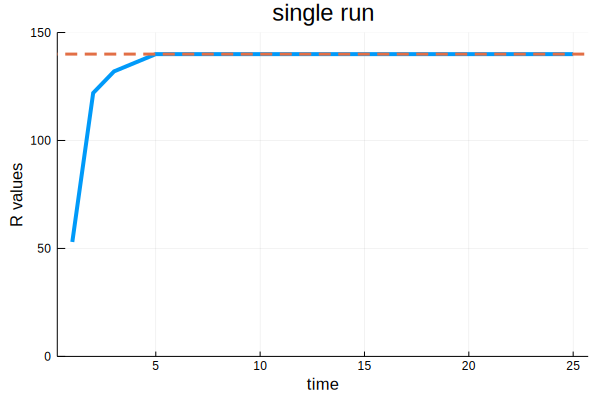

In [74]:

traceR = Int[]

for tt in 1:TT    
    append!(traceR,grid_satisfaction(gridDict[tt]))    
end
println(traceR)
println(typeof(traceR))
plt = plot(traceR,ylim=(0,R_MAX+10),leg=false,linewidth=4,titlefontsize=16,title="single run",xlabel="time",ylabel="R values")

#plot(traceR,ylim=(0,R_MAX+10),leg=false,guidefont=14,linewidth=4,xtickfontsize=10,ytickfontsize=10,titlefontsize=16,title="single run",xlabel="time",ylabel="R values")
hline!([R_MAX],line=(3,:dash),leg=false)

(25, 10)
[53.5; 125.1; 133.1; 135.1; 135.6; 136.7; 137.3; 137.4; 137.4; 137.4; 137.4; 137.4; 137.4; 137.4; 137.4; 137.4; 137.4; 137.4; 137.4; 137.4; 137.4; 137.4; 137.4; 137.4; 137.4]


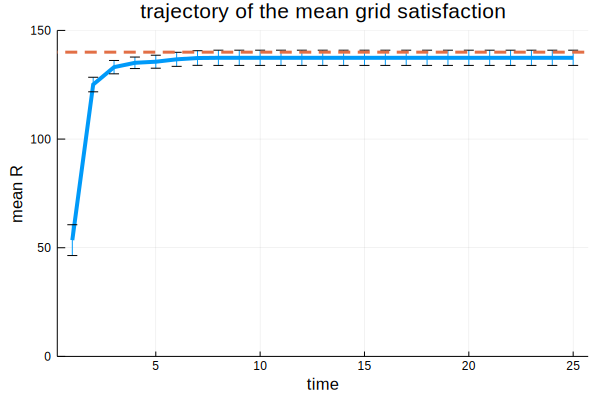

In [75]:
savefig(plt,"figs/singleRun.png")


simulationRvals = zeros(TT,MM)
for mm in 1:MM
    newGrid = shuffle(empty_grid)
    traceR = []
    append!(traceR,grid_satisfaction(newGrid))#initial time zero point
    for tt in 2:TT
        newGrid = move_cells_for_satisfaction(newGrid)
        append!(traceR,grid_satisfaction(newGrid))
    end
    simulationRvals[:,mm] = traceR[:]

end
    

println(size(simulationRvals))
println(mean(simulationRvals,dims=2))
plt = plot(mean(simulationRvals,dims=2),xlabel="time",ylabel="mean R",yerr=std(simulationRvals,dims=2),linewidth=4,ylim=(0,R_MAX+10),title="trajectory of the mean grid satisfaction") 
hline!([R_MAX],line=(3,:dash),leg=false)

In [76]:
savefig(plt,"figs/multipleRun.png")


println(simulationRvals[end,:])

[135.0, 129.0, 139.0, 140.0, 138.0, 139.0, 140.0, 139.0, 140.0, 135.0]


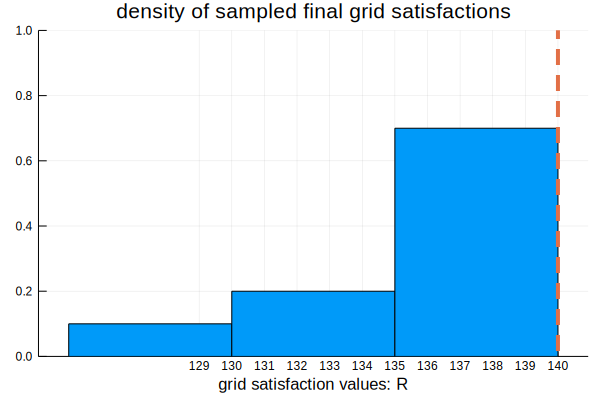

In [77]:
#get the histogram of the final values

pltHist = histogram(simulationRvals[end,:] .- 1,ylim=(0,1.0),xticks = (minimum(simulationRvals[end,:]):maximum(simulationRvals[end,:])) ,normalize=:probability,title="density of sampled final grid satisfactions",xlabel="grid satisfaction values: R",leg=false)#,xlim=(0,R_MAX+10)
vline!([R_MAX],line=(4,:dash),leg=false)



In [78]:
savefig(pltHist,"figs/finalHistRvals.png")


#sample random microstates
numberOfRandomSamples = 15000
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:numberOfRandomSamples]

#set the macrostate count array to those random allocations 
sampleCountsR = [length(findall(randomSatisfactions .== R)) for R in 1:R_MAX]
#println(sampleCountsR)
replace!(sampleCountsR,0=>1)
#println(sampleCountsR)
sampleProbR = sampleCountsR ./ sum(sampleCountsR)
#println(sampleProbR)
#println(sum(sampleProbR))

#The cellspace for the macrostates is the multiple of the probability
sampleOmegaR = sampleProbR .* CELLS_SPACE_SIZE
#println(sampleOmegaR)


println(sampleOmegaR)
println(size(sampleOmegaR))

BigFloat[2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 2.23084e+69, 4.46167e+69, 4.46167e+69, 6.69251e+69, 2.45392e+70, 2.23084e+70, 4.0155e+70, 6.24634e+70, 6.46942e+70, 9.81568e+70, 1.3385e+71, 2.00775e+71, 2.16391e+71, 2.63239e+71, 3.92627e+71, 4.72937e+71, 6.71482e+71, 6.75943e+71, 8.0087e+71, 9.16874e+71, 1.10203e+72, 1.24481e+72, 1.35858e+72, 1.49243e+72, 1.53482e+72, 1.56828e+72, 1.71997e+72, 1.70882e+72, 1.69097e+72, 1.64859e+72, 1.65305e+72, 1.45004e+72, 1.38758e+72, 1.34296e+72, 1.13773e+72, 1.17342e+72, 9.70414e+71, 8.47718e+71, 7.67408e+71, 5.46555e+71, 5.04169e+71, 4.14936e+71, 2.63239e+71, 2.4093e+71, 1.6062e+71, 1.13773e+71, 1.13773e+71, 7.58484e+70, 6.69251e

BigFloat[2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.2142e-21, 2.2142e-21, 2.2198e-21, 2.23774e-21, 2.23642e-21, 2.24454e-21, 2.25064e-21, 2.25112e-21, 2.25688e-21, 2.26116e-21, 2.26676e-21, 2.26779e-21, 2.2705e-21, 2.27602e-21, 2.27859e-21, 2.28343e-21, 2.28352e-21, 2.28586e-21, 2.28773e-21, 2.29027e-21, 2.29195e-21, 2.29316e-21, 2.29445e-21, 2.29484e-21, 2.29514e-21, 2.29641e-21, 2.29632e-21, 2.29618e-21, 2.29583e-21, 2.29586e-21, 2.29405e-21, 2.29345e-21, 2.293e-21, 2.29071e-21, 2.29113e-21, 2.28851e-21, 2.28664e-21, 2.28527e-21, 2.28058e-21, 2.27947e-21, 2.27678e-21, 2.2705e-21, 2.26927e-21, 2.26368e-21, 2.25892e-21, 2.25892e-21, 2.25332e-21, 2.25159e-2

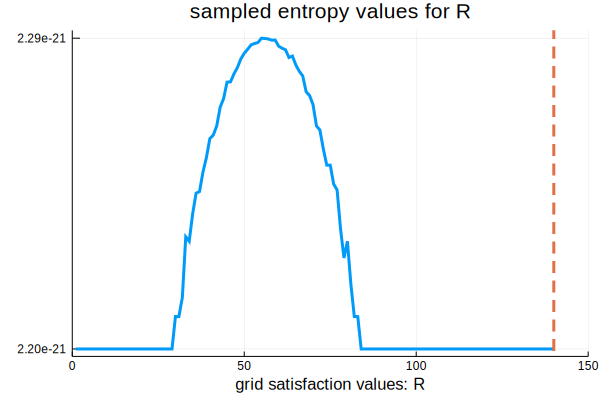

In [79]:
plt2 = plot(1:R_MAX,sampleOmegaR,xlim=(0,R_MAX+10),linewidth=3,title="sampled omega size for R",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)
savefig(plt2,"figs/sampledOmega.png")



function S_entropy_values_from_R(R)
    return k_b * log(sampleOmegaR[R])
       
end

entropyVals = [S_entropy_values_from_R(R) for R in 1:R_MAX]

println(entropyVals)
println(S_entropy_values_from_R(1),"---",S_entropy_values_from_R(round(Int,R_MAX/2)))

minStr = string(minimum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyVals)) )
tmp2 = string(minimum(entropyVals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyVals)) )
tmp2 = string(maximum(entropyVals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt4 = plot(1:R_MAX,entropyVals,
    yticks=([minimum(entropyVals),maximum(entropyVals)],[labelMin,labelMax]),
    xlim=(0,R_MAX+10),ylim=(minimum(entropyVals)*(1-(10^-3)),(1 + 10^-3)*maximum(entropyVals)),
    linewidth=3,title="sampled entropy values for R",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)

Any[56, 130, 130, 138, 138, 139, 139, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
Any[2.29632e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21]
-9.169141521470189947156236959176902669939606953458811056123274561835443035107931e-23
2.29e-212.20e-21


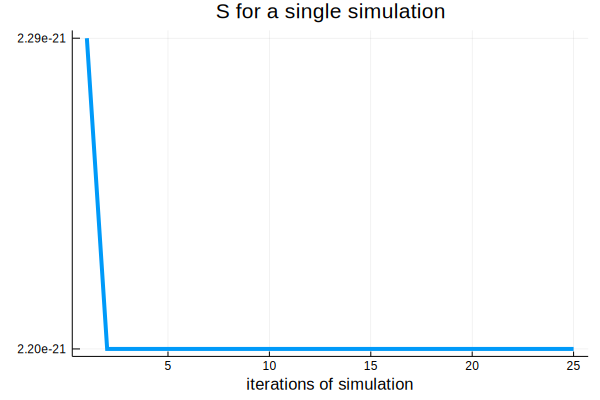

In [80]:
#plt3 = plot(1:R_MAX,entropyVals,xlim=(0,R_MAX+10),linewidth=3,title="sampled entropy values for R",xlabel="grid satisfaction values: R")
#vline!([R_MAX],line=(3,:dash),leg=false)
#savefig(plt3,"figs/sampledEntropy.png"
savefig(plt4,"figs/sampledEntropy.png")


#now do a single run trace with the entropy values and plot
traceR = Int[]
traceS = Int[]

newGrid = shuffle(empty_grid)
traceR = []
traceS = []
Rtmp = grid_satisfaction(newGrid)
append!(traceR,Rtmp)
append!(traceS,S_entropy_values_from_R(Rtmp))
for tt in 2:TT
    newGrid = move_cells_for_satisfaction(newGrid)
    Rtmp = grid_satisfaction(newGrid)
    append!(traceR,Rtmp)
    append!(traceS,S_entropy_values_from_R(Rtmp))
end
println(traceR)
println(traceS)

println( minimum(traceS) - maximum(traceS)   )


minStr = string(minimum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyVals)) )
tmp2 = string(minimum(entropyVals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyVals)) )
tmp2 = string(maximum(entropyVals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt5 = plot(traceS,yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),ylims=(minimum(traceS)*(1-(10^-3)),(1 + 10^-3)*maximum(traceS)),
    linewidth=4,title="S for a single simulation",xlabel="iterations of simulation",leg=false)


In [81]:
savefig(plt5,"figs/entropySingleSimulation.png")



(25, 10)
2.29e-212.20e-21


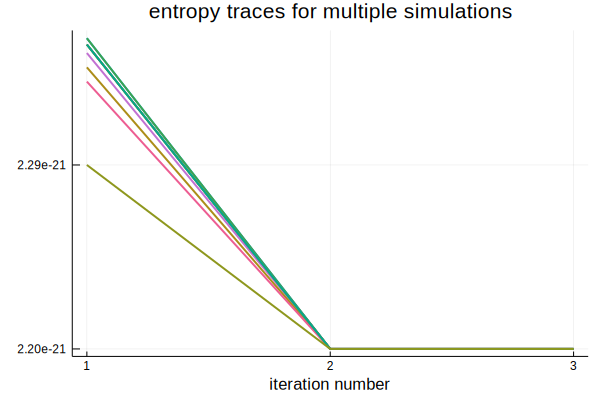

In [82]:


simulationSvals = zeros(TT,MM)
for mm in 1:MM
    traceR = Int[]
    traceS = Int[]

    newGrid = shuffle(empty_grid)
    traceR = []
    traceS = []
    Rtmp = grid_satisfaction(newGrid)
    append!(traceR,Rtmp)
    append!(traceS,S_entropy_values_from_R(Rtmp))
    for tt in 2:TT
        newGrid = move_cells_for_satisfaction(newGrid)
        Rtmp = grid_satisfaction(newGrid)
        append!(traceR,Rtmp)
        append!(traceS,S_entropy_values_from_R(Rtmp))
    end
    simulationSvals[:,mm] = traceS[:]

end

println(size(simulationSvals))
minimumS = minimum(simulationSvals)
maximumS = maximum(simulationSvals)



minStr = string(minimum(simulationSvals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(simulationSvals)) )
tmp2 = string(minimum(simulationSvals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(simulationSvals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(simulationSvals)) )
tmp2 = string(maximum(simulationSvals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt7 = plot(simulationSvals[1:3,1:end],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=2,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 


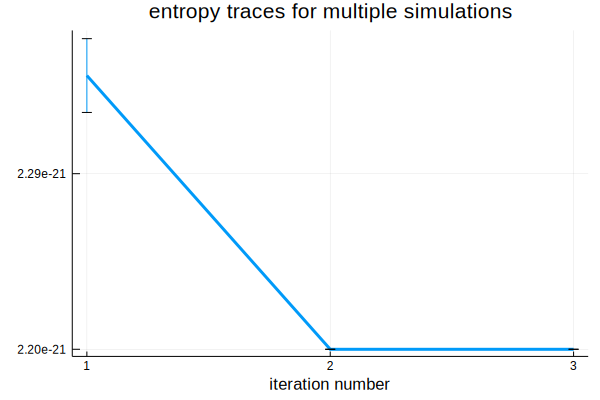

In [83]:
savefig(plt7,"figs/entropyMultipleSimulations.png")


plt8 = plot(mean(simulationSvals,dims=2)[1:3],
    yerr=std(simulationSvals,dims=2)[1:3],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 3*10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=3,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 



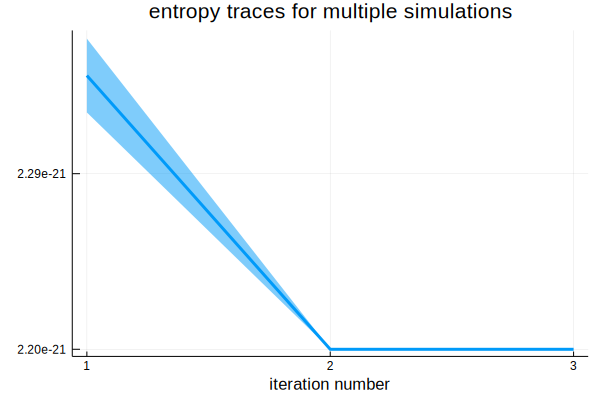

In [84]:
savefig(plt8,"figs/entropyMultipleSimulationsSpread.png")


plt9 = plot(mean(simulationSvals,dims=2)[1:3],
    ribbon=std(simulationSvals,dims=2)[1:3],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 3*10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=3,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 


In [85]:
savefig(plt9,"figs/entropyMultipleSimulationsSpreadRibbon.png")




In [86]:
##################
#FINANCE PART NOW!
##################


#wealth distribution data taken from: https://raw.githubusercontent.com/jkeesh/which-percent/master/data.csv
# It is based on data from the US census as well as the Social Security Administration
csvWealth = CSV.File("wealthDistribution.csv",header=false)
dfWealth = DataFrame(csvWealth)
percs = dfWealth[:,4]
percsNew=[percs[i][1:end-1] for i in 1:length(percs)]
percsNewNew = [ parse(Float64,percsNew[i]) for i in 1:length(percs)]


function df2wealthArray(dfWealth)
    meansBracket = []
    for i in 1:size(dfWealth)[1]
        
        inds = findall(isequal(' '),dfWealth[i,1])
        
        money1 = dfWealth[i,1][1:inds[1]-1]
        money2 = dfWealth[i,1][inds[2]+1:end]
        
        
        
        if(i == size(dfWealth)[1])
            money2 = money1
        end
        
        money1 = replace(money1,","=>"")
        money2 = replace(money2,","=>"")
        money1 = parse(Float64,money1)
        money2 = parse(Float64,money2)
        
        #println(mean([money1,money2]))
        append!(meansBracket,mean([money1,money2]))
        
    end
    return meansBracket
end
wealthBrackets = df2wealthArray(dfWealth)
percsAndWealth = hcat(percsNewNew,wealthBrackets) 
println(percsAndWealth)
println(percsAndWealth[1,:])


Any[100.0 2500.0; 85.7293 7499.99; 76.9745 12500.0; 69.1804 17500.0; 61.9069 22500.0; 55.0045 27500.0; 48.561 32500.0; 42.5631 37500.0; 37.1403 42500.0; 32.3649 47500.0; 28.2287 52500.0; 24.6107 57500.0; 21.5469 62500.0; 18.891 67500.0; 16.632 72500.0; 14.6756 77500.0; 12.9786 82500.0; 11.5263 87500.0; 10.2775 92500.0; 9.1938 97500.0; 8.254 102500.0; 7.4264 107500.0; 6.7202 112500.0; 6.1026 117500.0; 5.5552 122500.0; 5.0663 127500.0; 4.6402 132500.0; 4.2636 137500.0; 3.9302 142500.0; 3.635 147500.0; 3.3701 152500.0; 3.127 157500.0; 2.915 162500.0; 2.7278 167500.0; 2.5601 172500.0; 2.4087 177500.0; 2.272 182500.0; 2.1452 187500.0; 2.032 192500.0; 1.9275 197500.0; 1.8301 225000.0; 1.1727 275000.0; 0.8155 325000.0; 0.6046 375000.0; 0.4656 425000.0; 0.37 475000.0; 0.3012 750000.0; 0.0825 1.25e6; 0.0411 1.75e6; 0.0258 2.25e6; 0.0182 2.75e6; 0.0138 3.25e6; 0.0108 3.75e6; 0.0087 4.25e6; 0.0072 4.75e6; 0.0061 7.5e6; 0.002 1.5e7; 0.0006 3.5e7; 0.0001 5.0e7]
Any[100.0, 2500.0]


In [87]:
#now sample according to the population a wealth bracket

function wealthBracketSample()
    brackets = findall(isequal(true), rand()*100 .<= percsAndWealth[:,1] )
    maxBracketInd = maximum(brackets)
    #println(maxBracketInd)
    return percsAndWealth[maxBracketInd,2]
end

wealthSamples = [wealthBracketSample() for i in 1:10]
println(wealthSamples)


[375000.0, 7499.99, 17500.0, 77500.0, 52500.0, 22500.0, 750000.0, 2500.0, 2500.0, 2500.0]


--yellow mean--37214.28571428572--blue mean--36785.71428571428
std yellow sample 35415.6040517731
std blue sample 35193.93181272766
skewness yellow sample 1.6405212955010153
skewness blue sample 1.0466806797740196


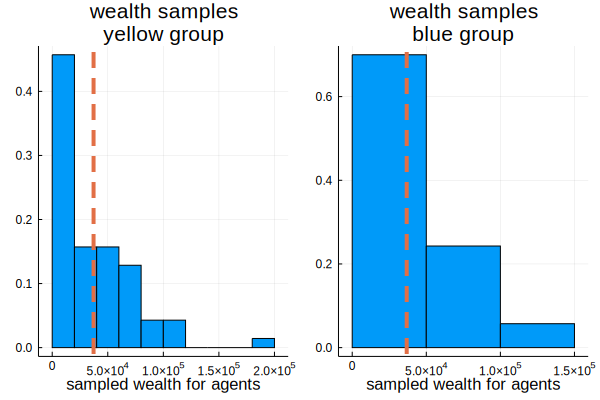

In [88]:

wealthSamplesYellow = [wealthBracketSample() for i in 1:yellow_count]
wealthSamplesYellow = round.(wealthSamplesYellow)
wealthSamplesBlue = [wealthBracketSample() for i in 1:blue_count]
wealthSamplesBlue = round.(wealthSamplesBlue)

println("--yellow mean--",mean(wealthSamplesYellow),"--blue mean--",mean(wealthSamplesBlue))

println("std yellow sample $(std(wealthSamplesYellow))")
println("std blue sample $(std(wealthSamplesBlue))")
println("skewness yellow sample $(skewness(wealthSamplesYellow))")
println("skewness blue sample $(skewness(wealthSamplesBlue))")

pltHistYellow = histogram(wealthSamplesYellow,normalize=:probability,title="wealth samples \n yellow group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesYellow)],line=(4,:dash),leg=false)

pltHistBlue = histogram(wealthSamplesBlue,normalize=:probability,title="wealth samples \n blue group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesBlue)],line=(4,:dash),leg=false)

plt2hist = plot(pltHistYellow,pltHistBlue)

[2500.0, 62500.0, 17500.0, 32500.0, 67500.0, 7500.0, 2500.0, 37500.0, 97500.0, 7500.0, 2500.0, 42500.0, 117500.0, 7500.0, 42500.0, 37500.0, 52500.0, 67500.0, 2500.0, 2500.0, 17500.0, 7500.0, 2500.0, 17500.0, 72500.0, 17500.0, 47500.0, 57500.0, 67500.0, 77500.0, 52500.0, 17500.0, 67500.0, 47500.0, 2500.0, 72500.0, 27500.0, 12500.0, 192500.0, 52500.0, 2500.0, 2500.0, 2500.0, 12500.0, 12500.0, 37500.0, 12500.0, 87500.0, 7500.0, 112500.0, 42500.0, 17500.0, 32500.0, 32500.0, 37500.0, 12500.0, 32500.0, 2500.0, 12500.0, 12500.0, 17500.0, 82500.0, 32500.0, 2500.0, 47500.0, 17500.0, 62500.0, 42500.0, 107500.0, 27500.0, 7500.0, 7500.0, 47500.0, 52500.0, 32500.0, 2500.0, 112500.0, 112500.0, 47500.0, 2500.0, 22500.0, 17500.0, 32500.0, 7500.0, 42500.0, 17500.0, 2500.0, 62500.0, 62500.0, 2500.0, 27500.0, 32500.0, 127500.0, 2500.0, 37500.0, 2500.0, 2500.0, 62500.0, 97500.0, 47500.0, 27500.0, 37500.0, 17500.0, 97500.0, 77500.0, 2500.0, 17500.0, 82500.0, 57500.0, 12500.0, 7500.0, 32500.0, 27500.0, 7750

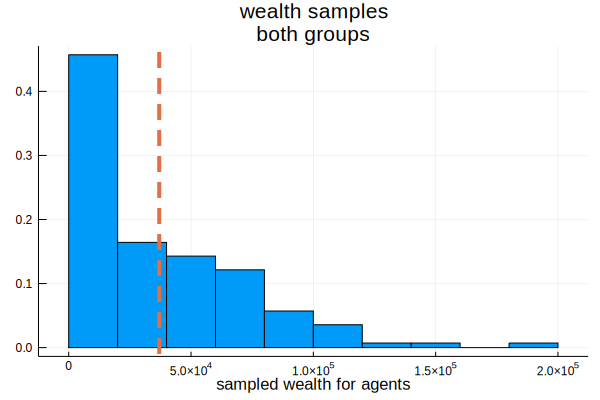

In [89]:

savefig(plt2hist,"figs/histwealthYellow.png")

totalWealthSamples = [wealthSamplesYellow ; wealthSamplesBlue]
println(totalWealthSamples)
println(size(totalWealthSamples))

pltHistTotal = histogram(totalWealthSamples,normalize=:probability,title="wealth samples \n both groups",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(totalWealthSamples)],line=(4,:dash),leg=false)


--yellowNormed mean--0.014285714285714285--blueNormed mean--0.014285714285714285
std yellowNormed sample 0.013595241478607713
std blueNormed sample 0.013667546335039863
skewness yellowNormed sample 1.6405212955010129
skewness blueNormed sample 1.04668067977402


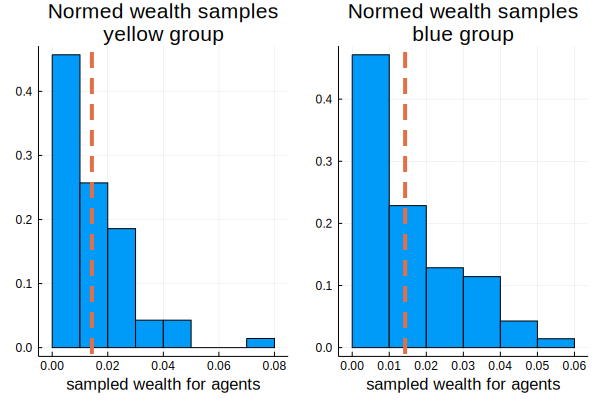

In [90]:

savefig(pltHistTotal,"figs/histwealthTotal.png")

wealthSamplesYellowNormed = wealthSamplesYellow ./ sum(wealthSamplesYellow)
wealthSamplesBlueNormed = wealthSamplesBlue ./ sum(wealthSamplesBlue)

println("--yellowNormed mean--",mean(wealthSamplesYellowNormed),"--blueNormed mean--",mean(wealthSamplesBlueNormed))

println("std yellowNormed sample $(std(wealthSamplesYellowNormed))")
println("std blueNormed sample $(std(wealthSamplesBlueNormed))")
println("skewness yellowNormed sample $(skewness(wealthSamplesYellowNormed))")
println("skewness blueNormed sample $(skewness(wealthSamplesBlueNormed))")

pltHistYellowNormed = histogram(wealthSamplesYellowNormed,normalize=:probability,title="Normed wealth samples \n yellow group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesYellowNormed)],line=(4,:dash),leg=false)

pltHistBlueNormed = histogram(wealthSamplesBlueNormed,normalize=:probability,title="Normed wealth samples \n blue group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesBlueNormed)],line=(4,:dash),leg=false)

plotNormedHists = plot(pltHistYellowNormed,pltHistBlueNormed)


In [91]:
savefig(plotNormedHists,"figs/histwealthYellow.png")


In [92]:
#in the finance grid we store both the type of agent and the financial part
function make_random_finance_grid()    
    empty_grid = zeros(GRID_SIZE,GRID_SIZE,2)
    shiftsTmp = GRID_SIZE^2;
    
    wealthSamplesYellow = [wealthBracketSample() for i in 1:yellow_count]
    wealthSamplesYellow = round.(wealthSamplesYellow)
    wealthSamplesBlue = [wealthBracketSample() for i in 1:blue_count]
    wealthSamplesBlue = round.(wealthSamplesBlue)
    
    
    NORMED = true
    if(NORMED == true)
        samplesYellow = wealthSamplesYellow ./ sum(wealthSamplesYellow)
        samplesBlue = wealthSamplesBlue ./ sum(wealthSamplesBlue)
    else
        samplesYellow = wealthSamplesYellow #./ sum(wealthSamplesYellow)
        samplesBlue = wealthSamplesBlue #./ sum(wealthSamplesBlue)
    end
    
    #set the agent occupations in the lattice
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    #set the financial values for the agents
    empty_grid[1+shiftsTmp:yellow_count+shiftsTmp] .= samplesYellow
    empty_grid[yellow_count+1+shiftsTmp:yellow_count+blue_count+shiftsTmp] .= samplesBlue
    
    indShuffle = shuffle(1:GRID_SIZE^2)
    indShuffle2 = indShuffle .+ GRID_SIZE^2
    empty_grid[1:GRID_SIZE^2] = empty_grid[indShuffle]
    empty_grid[1 .+ GRID_SIZE^2 : GRID_SIZE^2 .+ GRID_SIZE^2 ] = empty_grid[indShuffle2]
    #empty_grid[:,:,2] = shuffle(empty_grid[:,:,2])
    
    return empty_grid
end

moneyGrid = make_random_finance_grid()
println(moneyGrid)
println(sum(moneyGrid))
println(length(findall(moneyGrid[:,:,2] .!= 0)))
b1 = (moneyGrid[:,:,2] .== 0.0)
b2 = (moneyGrid[:,:,1] .== 0.0)
println(count(isequal.(b1,b2)))
println("cool if true...=$(count(isequal.(b1,b2))==GRID_SIZE^2)")

[0.0 -1.0 -1.0 -1.0 -1.0 1.0 1.0 -1.0 0.0 0.0 1.0 0.0 -1.0; -1.0 0.0 1.0 1.0 -1.0 -1.0 1.0 1.0 1.0 -1.0 -1.0 0.0 1.0; 1.0 1.0 -1.0 1.0 1.0 -1.0 1.0 -1.0 -1.0 -1.0 0.0 -1.0 -1.0; 1.0 1.0 0.0 -1.0 0.0 -1.0 -1.0 1.0 1.0 0.0 -1.0 1.0 -1.0; 1.0 1.0 1.0 -1.0 0.0 -1.0 0.0 1.0 0.0 -1.0 0.0 -1.0 1.0; 0.0 -1.0 -1.0 1.0 1.0 0.0 0.0 1.0 -1.0 1.0 -1.0 -1.0 -1.0; 1.0 1.0 -1.0 1.0 1.0 1.0 1.0 0.0 -1.0 -1.0 1.0 0.0 1.0; 1.0 1.0 1.0 -1.0 1.0 1.0 -1.0 -1.0 1.0 -1.0 1.0 -1.0 -1.0; -1.0 0.0 1.0 -1.0 1.0 -1.0 1.0 1.0 1.0 1.0 -1.0 1.0 -1.0; 1.0 1.0 1.0 -1.0 1.0 0.0 -1.0 1.0 1.0 -1.0 0.0 -1.0 1.0; 1.0 1.0 -1.0 0.0 -1.0 1.0 -1.0 -1.0 1.0 -1.0 0.0 1.0 -1.0; -1.0 -1.0 0.0 0.0 -1.0 -1.0 -1.0 -1.0 1.0 1.0 -1.0 1.0 0.0; 0.0 0.0 1.0 -1.0 -1.0 1.0 -1.0 1.0 1.0 -1.0 -1.0 1.0 -1.0]

[0.0 0.0132383 0.0397149 0.00305499 0.0173116 0.0145929 0.00230415 0.00916497 0.0 0.0 0.0176651 0.0 0.0112016; 0.0376782 0.0 0.0238095 0.00537634 0.0376782 0.00101833 0.0145929 0.0529954 0.00384025 0.00101833 0.0213849 0.0 0.000768049; 0.0

In [93]:
#get the financial surroundings
function cell_surround_arrayTMP_financial(gridFull,row,col,third)
    grid = gridFull[:,:,third]
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end

    return cell_surrounding
end
arrayCellFinance = cell_surround_arrayTMP_financial(moneyGrid,11,12,2)
println(arrayCellFinance)
arrayCellType = cell_surround_arrayTMP_financial(moneyGrid,11,12,1)
println(arrayCellType)

Any[0.0, 0.00305499, 0.0207373, 0.0, 0.0112016, 0.0132383, 0.00230415, 0.0]
Any[0.0, -1.0, 1.0, 0.0, -1.0, -1.0, 1.0, 0.0]


In [94]:

#the equivalent of 'thresholdFN' that examines a locality to see financial deviation
function financial_cell_deviation(gridFull,cellSurroundArray,row,col)
    cellFinance = gridFull[row,col,2]
    if(cellFinance == 0)
        return 0
    end
    #println(cellFinance)    
    deviation = mad(cellSurroundArray,center=cellFinance,normalize=false)
    return deviation
    
end

moneyDeviation = financial_cell_deviation(moneyGrid,arrayCellFinance,11,12)
println(moneyDeviation)
println(moneyGrid[11,12,2])


0.024202151789038326
0.026881720430107527


In [95]:
#find the total deviation for the cells finances
function financial_grid_deviation(gridFull)
    #grid = gridFull[:,:,2]
    cell_deviation = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            arrayCellFinance = cell_surround_arrayTMP_financial(gridFull,row,col,2)
            #t=cell_surround_arrayTMP(grid,row,col)  #R2 = R_grid(start_grid)
            moneyDeviation = financial_cell_deviation(gridFull,arrayCellFinance,row,col)
            #tmpBinary = thresholdFN(t,grid[row,col],row,col)
            append!(cell_deviation,moneyDeviation)
        end
    end    
    return sum(cell_deviation)    
    
end
gridDeviationMedians = financial_grid_deviation(moneyGrid);
println(gridDeviationMedians)
println("yay")
 
x = [financial_grid_deviation(make_random_finance_grid()) for i in 1:100]
println(mean(x))
println(minimum(x))
println(maximum(x))

1.8104670552275839
yay
1.804576253324369
1.5760788050229884
2.00428389475986


mean of the deviations for the sampled= 1.81251519765195


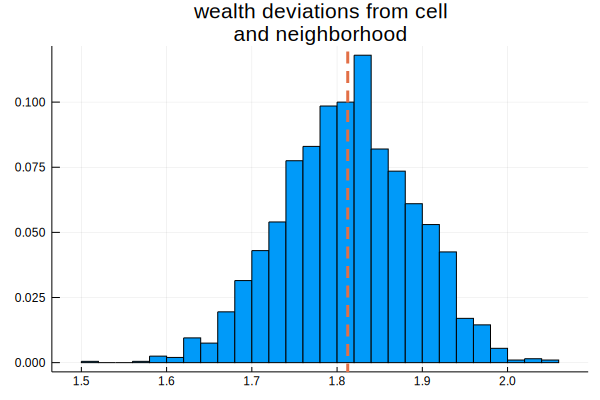

In [96]:
#try running the random deviations over a set to see the distribution
numberOfRandomSamples = 2000
randomMoneyDeviations = [ financial_grid_deviation(make_random_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealSampleMoneyDeviations = mean(randomMoneyDeviations)

println("mean of the deviations for the sampled= $(mean(randomMoneyDeviations))")
pltHist = histogram(randomMoneyDeviations,leg=false,normalize=:probability,
    title="wealth deviations from cell\n and neighborhood")
vline!([mean(randomMoneyDeviations)],line=(3,:dash),leg=false)



[0.403543, 0.35394, 0.0624289, 0.833732, 0.957904, 0.922843, 0.250296, 0.330964, 0.514329, 0.106438]
[0.0160646, 0.0168639, 0.0160012, 0.00336685, 0.014206, 0.00813696, 0.00182199, 0.00195901, 0.0075042, 0.0121312, 0.0270932, 0.0215937, 0.0124955, 0.0278205, 0.0143467, 0.00682612, 0.00726959, 0.00552085, 0.019957, 0.00166544, 0.0181429, 0.00429119, 0.00489115, 0.0245464, 0.0171359, 0.00798445, 0.0261976, 0.0241367, 0.00307421, 0.00877576, 0.00480073, 0.0141032, 0.0114667, 0.0222512, 0.0189085, 0.0218888, 0.010863, 0.00206042, 0.00741536, 0.0263671, 0.0147425, 0.0290133, 0.0134325, 0.0298388, 0.0205175, 0.0189137, 0.004009, 0.0210379, 0.0211552, 0.00480388, 0.0133627, 0.00175804, 0.0282902, 0.00925519, 0.024096, 0.0156692, 0.0123111, 0.010983, 0.022754, 0.0178965, 0.00491268, 0.0139415, 0.0212196, 0.0207641, 0.0283035, 0.00249288, 0.0126483, 0.016355, 0.0214551, 0.00212137]
2.000000000000001
mean of the deviations for he uniform sampled= 1.4406727905429553


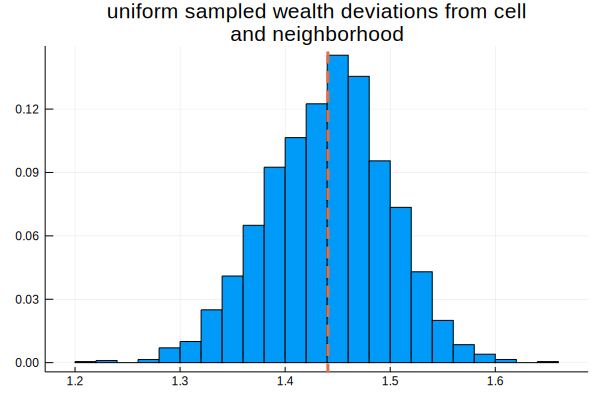

In [110]:
savefig(pltHist,"figs/histwealthSampleDeviations.png")

function randUniformWealthBracketSample()
    #row = Int(round(rand() * size(percsAndWealth)[1]))
    return rand()
end

wealthSamples = [randUniformWealthBracketSample() for i in 1:10]
println(wealthSamples)


#in the finance grid we store both the type of agent and the financial part
yellowUniformSample = [randUniformWealthBracketSample() for i in 1:yellow_count]
blueUniformSample = [randUniformWealthBracketSample() for i in 1:blue_count]

NORMED = true

if(NORMED == true)
    wealthSamplesYellowUniformSampled = yellowUniformSample ./ sum(yellowUniformSample)
    wealthSamplesBlueUniformSampled = blueUniformSample ./ sum(blueUniformSample)
    println(wealthSamplesBlueUniformSampled)
else
    wealthSamplesYellowUniformSampled = yellowUniformSample #./ sum(yellowUniformSample)
    wealthSamplesBlueUniformSampled = blueUniformSample# ./ sum(blueUniformSample)
end

    
function make_uniform_sampled_finance_grid()    
    empty_grid = zeros(GRID_SIZE,GRID_SIZE,2)
    shiftsTmp = GRID_SIZE^2;
    
    #set the agent occupations in the lattice
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    #set the financial values for the agents
    empty_grid[1+shiftsTmp:yellow_count+shiftsTmp] .= wealthSamplesYellowUniformSampled
    empty_grid[yellow_count+1+shiftsTmp:yellow_count+blue_count+shiftsTmp] .= wealthSamplesBlueUniformSampled
    
    empty_grid[:,:,1] = shuffle(empty_grid[:,:,1])
    empty_grid[:,:,2] = shuffle(empty_grid[:,:,2])
    return empty_grid
end

moneyGridUniformSampled = make_uniform_sampled_finance_grid()
println(sum(moneyGridUniformSampled))


randomUniformMoneyDeviations = [ financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealUniformMoneyDeviations = mean(randomUniformMoneyDeviations)

println("mean of the deviations for he uniform sampled= $(mean(randomUniformMoneyDeviations))")
pltHistUniform = histogram(randomUniformMoneyDeviations,leg=false,normalize=:probability,title="uniform sampled wealth deviations from cell\n and neighborhood")
vline!([mean(randomUniformMoneyDeviations)],line=(3,:dash),leg=false)


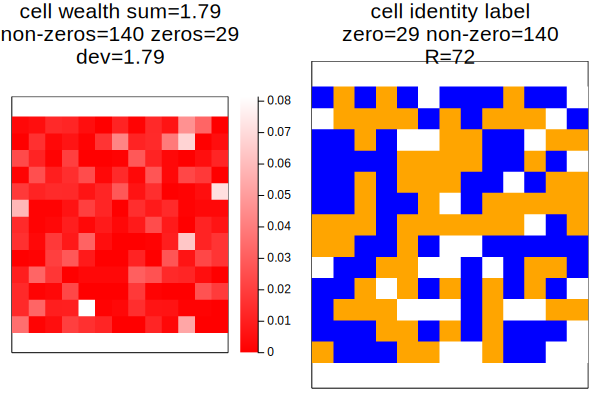

1


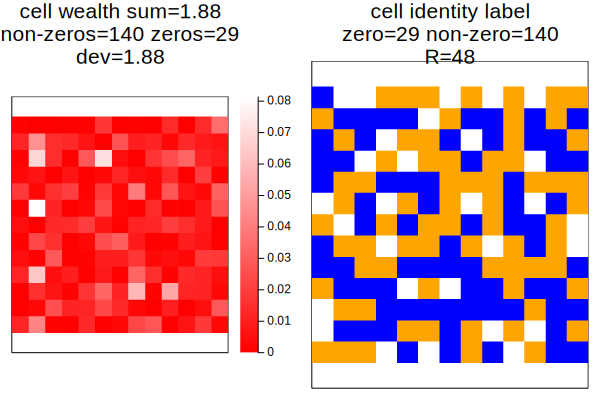

2


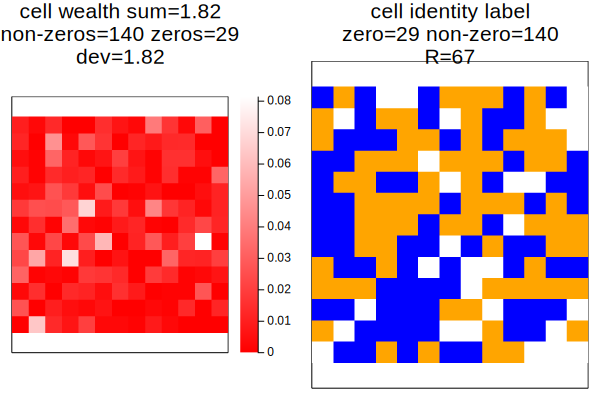

3


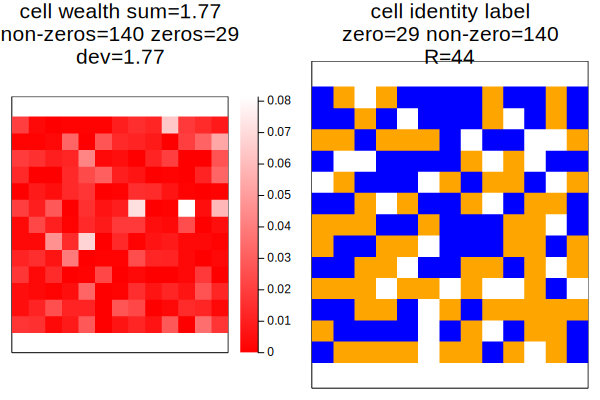

4


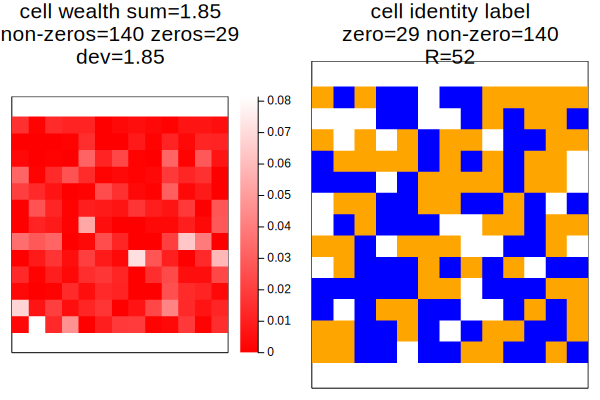

5


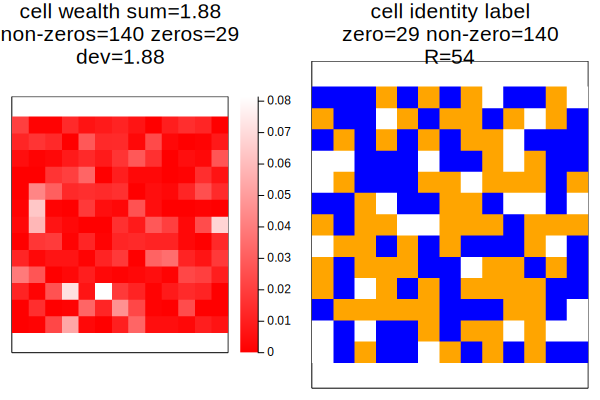

6


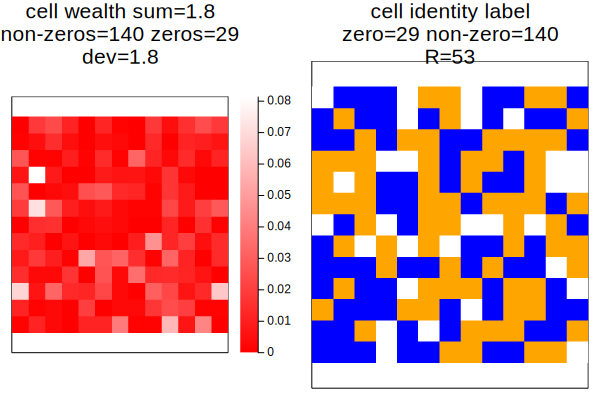

7


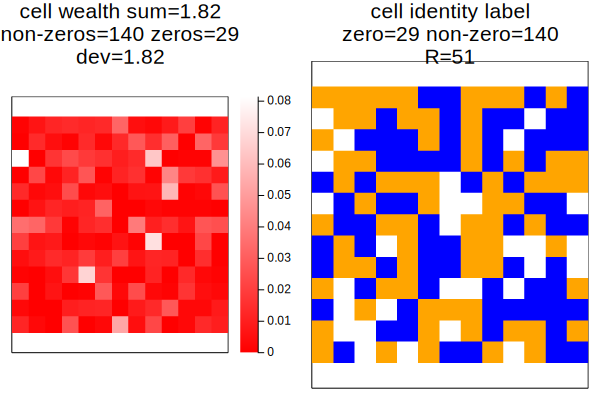

8


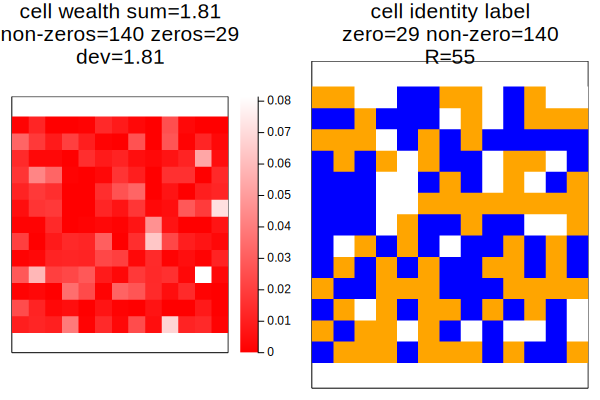

9


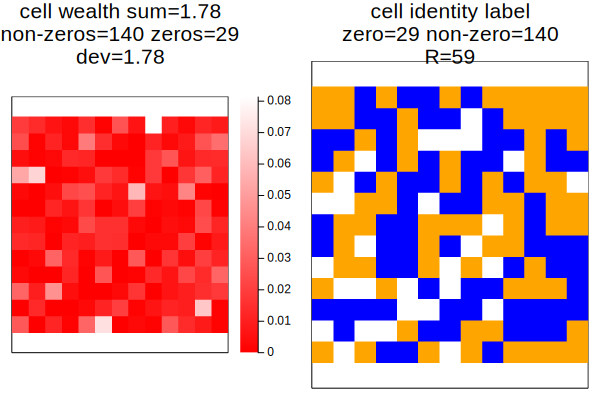

10


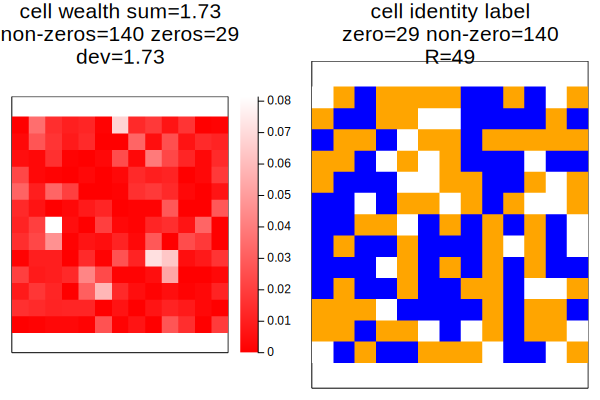

11


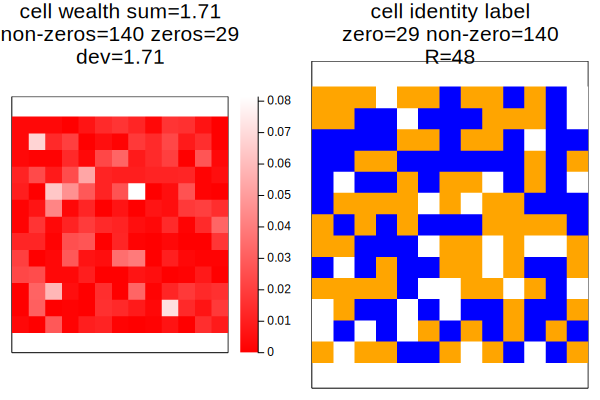

12


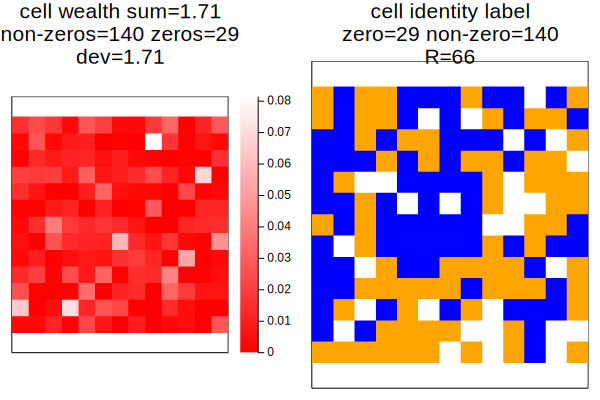

13


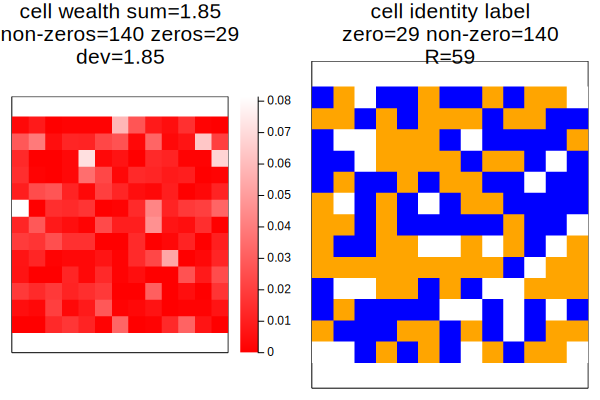

14


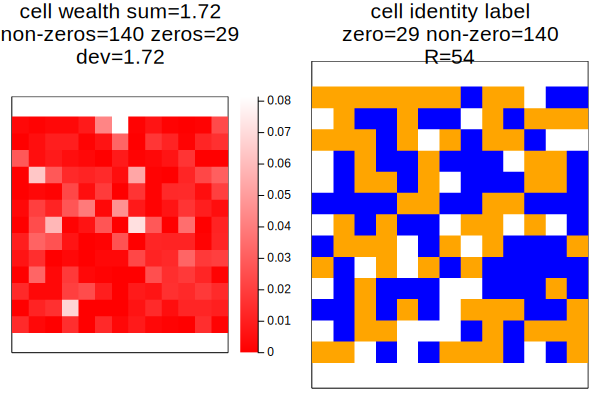

15


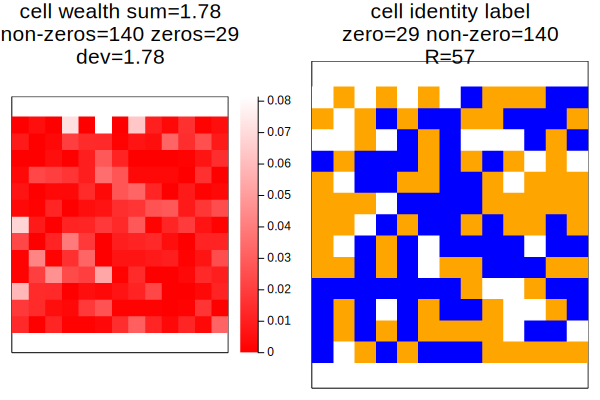

16


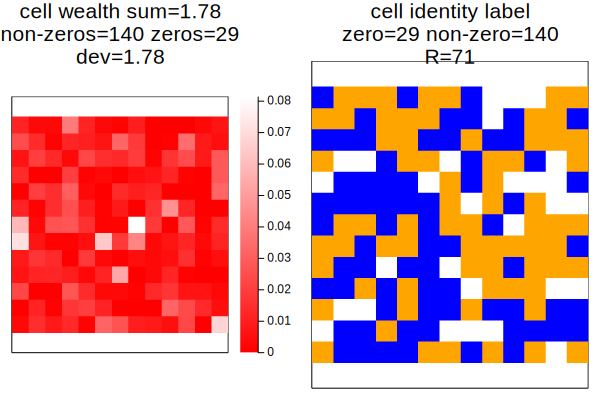

17


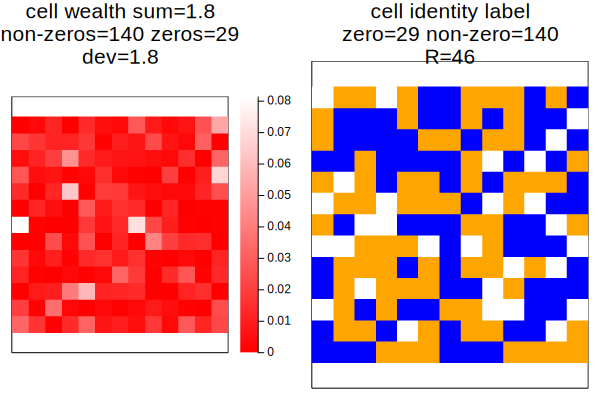

18


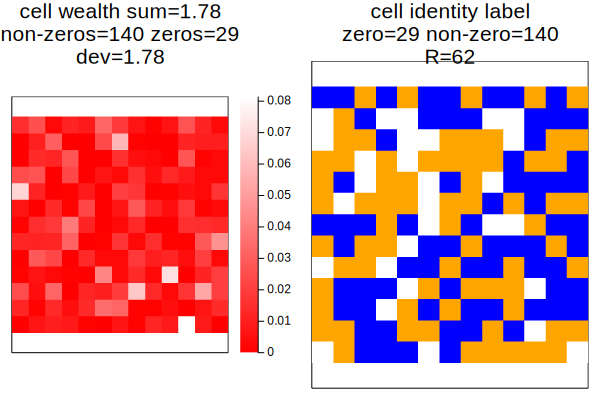

19


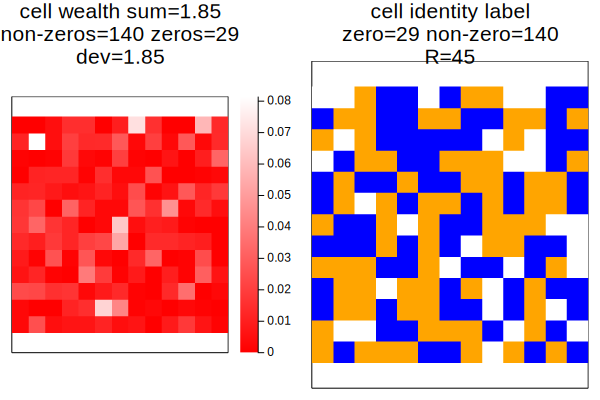

20


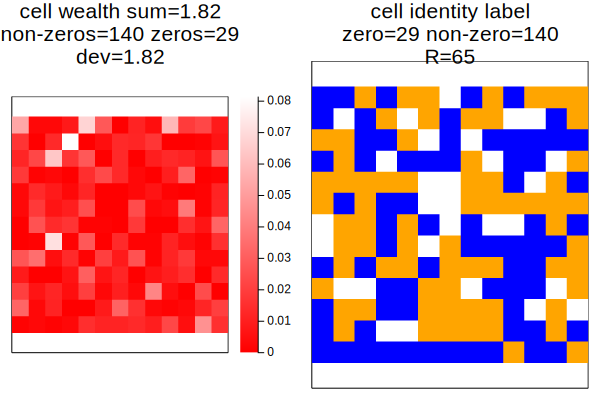

21


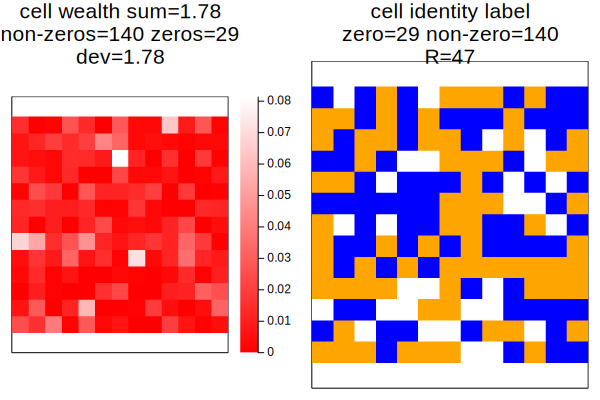

22


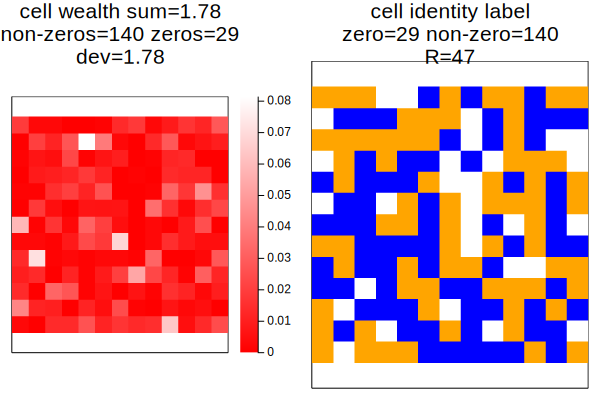

23


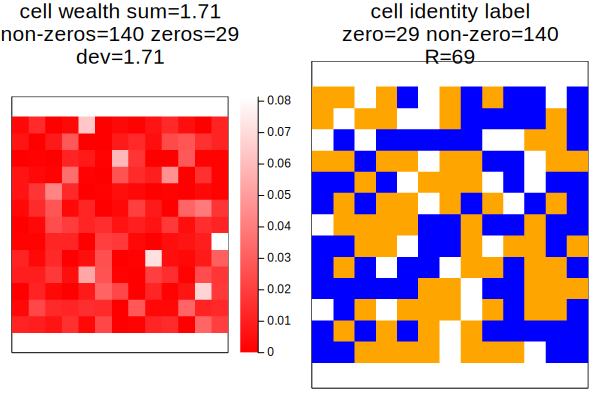

24


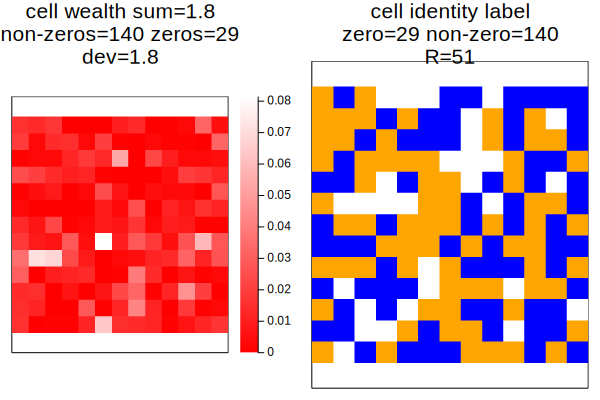

25
---
x=1.7989925059887113
x2=1.7734783141678854


In [111]:
savefig(pltHistUniform,"figs/histwealthUniformSampleDeviations.png")


#wealth no dynamics just moves the cells around randomly and continuously and at each iteration check the 
#financial cell deviation at each iteration, and at each move ...
#pick a random percentage of the wealth and radiate that amongst the neighbors
function move_cells_for_wealth_NoDynamics(grid)
    
    #grid = deepcopy(gridOrig) 
    
    nonZeroCells = findall(grid[:,:,1] .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)
        
    
    for nzc in nonZeroCells2 
        emptyCells = findall(grid[:,:,1] .== 0)
        emptyCells2 = shuffle(emptyCells)
        ec = emptyCells2[1]
        grid[ec[1],ec[2],1] = grid[nzc[1],nzc[2],1]
        grid[nzc[1],nzc[2],1] = 0
        
        
           
        grid[ec[1],ec[2],2] = grid[nzc[1],nzc[2],2]
        grid[nzc[1],nzc[2],2] = 0 
        #radiate the finance randomly on the surroundings
        #grid = cell_surround_radiate_financialRandomUniform!(grid,ec[1],ec[2])
        
            
    end          
    #println(g2[:,:,1] == newGrid2[:,:,1])
    return grid
end

traceR = zeros(TT)
traceWD = zeros(TT)
 
for tt in 1:TT   
    println(tt)
    if(tt==1)
        moneyGrid = make_random_finance_grid()  
    else
        moneyGrid =  move_cells_for_wealth_NoDynamics(moneyGrid) #make_random_finance_grid()  
    end
    
        
    traceR[tt] = grid_satisfaction(moneyGrid[:,:,1])
    traceWD[tt] = financial_grid_deviation(moneyGrid)
    wdevTmp = financial_grid_deviation(moneyGrid)
    Rtmp = grid_satisfaction(moneyGrid[:,:,1])
    tmp = round(sum(wdevTmp),digits=2)
    tmp2 = length(findall(moneyGrid[:,:,1] .!= 0))
    tmp2b = length(findall(moneyGrid[:,:,1] .== 0))
    tmp3 = length(findall(moneyGrid[:,:,2] .== 0))
    tmp4 = length(findall(moneyGrid[:,:,2] .!= 0))
    
    hm = heatmap(moneyGrid[:,:,2],title="cell wealth sum=$(tmp) \n non-zeros=$(tmp4) zeros=$(tmp3) \n dev=$(round(wdevTmp,digits=2))",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,
        framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=true,
    c=ColorGradient([:red,:white]))
    hm2 = heatmap(moneyGrid[:,:,1],title="cell identity label \n zero=$(tmp2b) non-zero=$(tmp2) \n R=$(Rtmp)",
        showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
        c=ColorGradient([:orange,:white,:blue]))

    p1=plot(hm,hm2)
    display(p1)
    savefig(hm,"figs/simulationSnapShots2/time$(tt).png")
end

println("---")
x = mean([financial_grid_deviation(make_random_finance_grid()) for i in 1:10])
println("x=$(x)")
x2 = mean([financial_grid_deviation(move_cells_for_wealth_NoDynamics(make_random_finance_grid())) for i in 1:10])
println("x2=$(x2)")

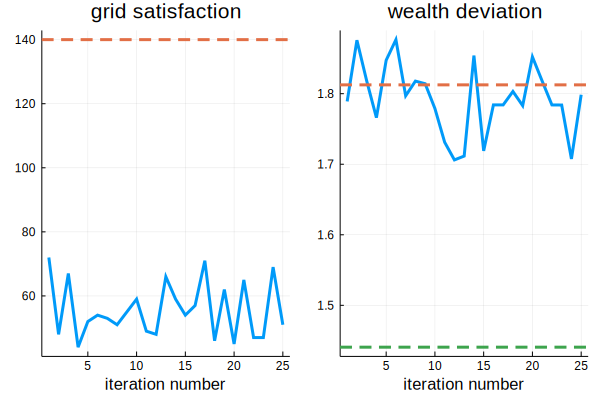

In [112]:


p1 = plot(traceR,linewidth=3,title="grid satisfaction",xlabel="iteration number")
hline!([R_MAX],line=(3,:dash),leg=false)
p2 = plot(traceWD,linewidth=3,title="wealth deviation",xlabel="iteration number")
hline!([mean(randomMoneyDeviations)],line=(3,:dash),leg=false)
hline!([mean(randomUniformMoneyDeviations)],line=(3,:dash),leg=false)
pboth = plot(p1,p2)
display(pboth)
savefig(pboth,"figs/RandWealthDevRandomNoDynamics.png")



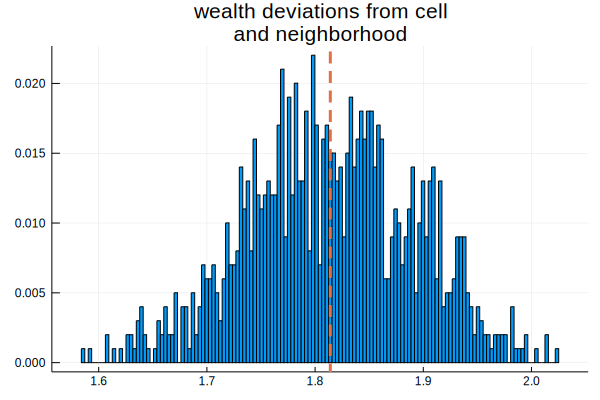

mean of the deviations for the sampled= 1.8140677774268834
1.081604934599576117230107426873479662810357394634400364697175441533851924587982e+72
6.008916303330978834426470349164634536657000075113544853140895540310161781502342e+70


In [135]:
#R_MAX
#now compute the sampled distribution for the probability of the different bins
numberOfRandomSamples = 1000
randomMoneyDeviations = [ financial_grid_deviation(make_random_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealSampleMoneyDeviations = mean(randomMoneyDeviations)

println("mean of the deviations for the sampled= $(mean(randomMoneyDeviations))")
pltHist = histogram(randomMoneyDeviations,leg=false,normalize=:probability,
    bins=range(minimum(randomMoneyDeviations),stop = maximum(randomMoneyDeviations),length=R_MAX),
    title="wealth deviations from cell\n and neighborhood")
vline!([mean(randomMoneyDeviations)],line=(3,:dash),leg=false)
display(pltHist)
savefig(pltHist,"figs/RawWealthDeviationsSample.png")


#MACROSTATE SEPARATOR parameter manually fixed as a bin size
SEPBIN = 0.01
roundDigits = 2

#now sample deviations for the probability distribution to be produced for the entropy later
numberOfRandomSamples = 200
randomMoneyDeviations = [ financial_grid_deviation(make_random_finance_grid()) for x in 1:numberOfRandomSamples]
randomMoneyDeviations = round.(randomMoneyDeviations,digits=roundDigits)
#set the maximum macrostate counts to be 
maxDev = round(2 * maximum(randomMoneyDeviations),digits=roundDigits)
moneyDeviationBins = collect(range(0,step=SEPBIN,stop=maxDev))
#println(randomMoneyDeviations)
binsDevCounts = [length( findall( dev .== randomMoneyDeviations ) ) for dev in moneyDeviationBins]
replace!(binsDevCounts,0=>1)
binsDevCountsProb = binsDevCounts ./ sum(binsDevCounts)
binsDev = collect( 0:SEPBIN:length(moneyDeviationBins) .* SEPBIN )
dictBinsWealthDevProb = Dict(zip(binsDev,binsDevCountsProb))

#println(dictBinsWealthDevProb)
#println(dictBinsWealthDevProb[1.8])

sampleOmegaB = binsDevCountsProb .* CELLS_SPACE_SIZE
#println(sampleOmegaB)
dictBinsWealthDevOmegaB = Dict(zip(binsDev,sampleOmegaB))

#println(dictBinsWealthDevOmegaB)
#println(dictBinsWealthDevOmegaB[1.8])
#println(dictBinsWealthDevOmegaB[1.1])



In [100]:

#savefig(hm,"figs/simulationSnapShots1/time$(tt).png")

#update the 
function cell_surround_radiate_financialRandomUniform!(grid,row,col)
    g2 = deepcopy(grid)
    newWealth = rand() * grid[row,col]
    radiate = grid[row,col] - newWealth
    
    #find neighbor number
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                if(grid[row-1+(ii),(col-1)+(jj)] != 0) 
                    append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])              
                end
            end
        end
    end
    neighborNum = length(cell_surrounding)
    #println(neighborNum)
    
    rTmp = rand(neighborNum)
    rTmpNorm = rTmp ./ sum(rTmp)
    radiateDist = radiate .* rTmpNorm
    
    ind = 1
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                if(grid[row-1+(ii),(col-1)+(jj)] != 0) 
                    grid[row-1+(ii),(col-1)+(jj)] = 10+radiateDist[ind] + grid[row-1+(ii),(col-1)+(jj)]             
                    ind += 1
                    #print("$(grid[row-1+(ii),(col-1)+(jj)])--")
                end
            end
        end
    end   
    #println("--")
    #println(g2 == grid)
    return grid
end










cell_surround_radiate_financialRandomUniform! (generic function with 1 method)

In [101]:

##just make a function to move the sampled agents around and see if the deviation is altered
#take the trace over time and since thre is no dynamics move one cell randomly at a time 
#but they do still radiate their money randomly and uniformly upon their destination locality
#where they end up, plot hlines for the means of the the two histograms above
#look at the results for starting with the uniform and real data to see if the deviation goes up or down...
#then do the randoml movement but people only move into areas where they have more than the median of
#the locality. and 
#on arrival disperse radially a random percentage of their wealth around them.
#check the median and mean deviations for th grid overt that time and check to see if it locks as
#if there is a point where the movement stops. 

#schelling said that the small changes in probability can have drastic effects. and that these
#preferencces can be so small that even the agents themselves the residents are not 
#aware of their biases because of the effects on the macrostate examining individuals
#may not be a viable solution. Therefore examining the macrostate and the change in the
#entropy would be a more sensitive and reslient approach. the minor amplificiations on
#the agent level can produce massive combinational changes on the macrostate.
#it also reacts quickly!

#the radial disperal at the start is benign, but afterwards the high wealth individuals
#create a block for the low to now enter like in physics for the satisfaction of new
#molecular bonds in how satisfied they will be. That is the same as 'gentrification'
 
#we get wealth samples, and sample from that for the allocations and then the wealth on movement 
#that here is initially random that gets radially distributed.
#how many random allocations of the financial units would it take to arrive at the 
#distribution of the wealth indicators
#eg, we start out with wealth sampled from the CDF, we allocate them to the residents. 
#they then move around randomly without homogeneity search
#we then do a set of random allocations of the funds to get a distribution for the variance 
#of the wealth and the skew so that we can say that the macro state variable is the variance and skew

#later we do the model that has both the homogeneity and the financial indicators and get the macrostate trajectory

#question: we need to have the purchasing to be constrained so that they cannot move forever 
#or that we can regulated it according to the size of the system.
#if tons of wealth is dropped it can go forever? or can we say that the wealth 
#movement is a relative measure? the relative measure would be more robust but the constrained version
#should also work.

In [102]:
#now to find a model that respects an increasing entropy value trace
#now to do the financial part...


#when an agent moves into a new place, they subtract the averagej from themselves
#and distribute that radially amongst the surrounding people.

#what is the accumulated gaps (disparity) ....of the wealth on the local levels..! :)
#take the min and max due to corners, then we keep that difference, and take the accumulation 
#of the total differences
#we simply compare that aggregate to the aggregates of the random initial samples...



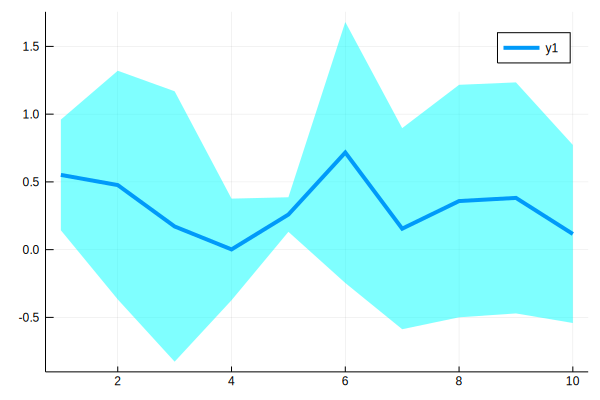

In [103]:
 plot(rand(10),ribbon=rand(10),fill=:cyan,linewidth=4)

In [104]:
function f1(x)
    x = x^2
    return x+x
end

f1 (generic function with 1 method)

In [105]:
x=3
println(f1(x))

18


$$\lambda + \beta$$
$$\frac{12}{4}$$

In [106]:
#old code


function grid_satisfactionOLD(start_grid) 
cell_satisfaction = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            cell_surrounding = []
            if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
                for ii in 0:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
                for ii in 0:1
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==1))#top left corner
                for ii in 1:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==GRID_SIZE))#top right corner
                for ii in 1:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==1))#bottom left corner
                for ii in 0:1
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
                for ii in 1:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
                for ii in 0:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
                for ii in 0:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
                for ii in 0:1
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
        end
    end
#println(cell_satisfaction)
#println(size(cell_satisfaction))
#println(sum(cell_satisfaction))

    return sum(cell_satisfaction)
end

satisfiedOneGrid = grid_satisfactionOLD(start_grid)
println("random grid satisfactionOLD value=",satisfiedOneGrid)
R_MAX = grid_satisfactionOLD(set_grid)
println("set grid satisfactionOLD value=",R_MAX)

random grid satisfactionOLD value=85
set grid satisfactionOLD value=140


In [107]:

#=
moneyGrid2 = move_cells_for_wealth_NoDynamics(moneyGrid)

println("---")
println("number of empty resident cells=",length(findall(moneyGrid2[:,:,1] .== 0)))
println("nmber of empty finance cells=",length(findall(moneyGrid2[:,:,2] .== 0)))
println("sum of total finance on finance cells=",sum(moneyGrid2[:,:,2]) )  
println("grid the same as before for residential=",moneyGrid2[:,:,1] == moneyGrid[:,:,1])
println("grid the same as before for finance=",moneyGrid2[:,:,2] == moneyGrid[:,:,2])
println("financial grid deviation=",financial_grid_deviation(moneyGrid))
println("financial grid2 deviation=",financial_grid_deviation(moneyGrid2))
println("grid2 satisfaction=",grid_satisfaction(moneyGrid2[:,:,1]))
println("---")

wdevTmp = round(financial_grid_deviation(moneyGrid2),digits=2)    
Rtmp = grid_satisfaction(moneyGrid2[:,:,1])
hm = heatmap(moneyGrid2[:,:,2],title="cell wealth \n deviation=$(wdevTmp)",
showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,
    framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=true,
c=ColorGradient([:red,:white]))
hm2 = heatmap(moneyGrid2[:,:,1],title="cell identity label \n R=$(Rtmp)",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))

p2=plot(hm,hm2)
display(p2)
#savefig(hm,"figs/simulationSnapShots1/time$(tt).png")
=#
